In [80]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score,  plot_confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [90]:
# Run Random forest model and output accuracy

def create_train_test_df(data_file, label_file):
    traintest_labels = pd.read_csv(label_file)
    traintest_labels["Datafile"] = traintest_labels["Datafile"].str.slice(10,)
    
    #import extracted_features file
    traintest_df = pd.read_csv(data_file)
    
    # merge with training/test labels to create final df
    final_df = pd.merge(traintest_df, traintest_labels, left_on='id', right_on = 'Datafile', how = 'inner')
    final_df = final_df[final_df['Label'] != 'lay']
    
    #remove Nan values if any
    final_df.replace(np.nan, 0.0, inplace = True)
    
    final_df.drop(['Datafile', 'id'], axis=1, inplace = True)
    
    return final_df



def create_train_test_sets(train_df, test_df):
    
    #convert label to numeric data for ML algos
    label_encoder = LabelEncoder()
    train_df['Label'] = label_encoder.fit_transform(train_df['Label'])
    #Encode Subject for leave one group out cross validation
    train_df['Subject'] = label_encoder.fit_transform(train_df['Subject'])
    
    test_df['Label'] = label_encoder.fit_transform(test_df['Label'])
    
    #create train and test sets
    X_train = train_df.drop(['Label'], axis=1)
    y_train = train_df['Label']
    
    X_test = test_df.drop(['Label'], axis=1)
    y_test = test_df['Label']
    
    return X_train, y_train, X_test, y_test


def rf_cls(X_train, y_train, X_test, y_test):
    
    # Create the model with best hyperparameters trees
    model = RandomForestClassifier(n_estimators = 1000, random_state = 4, n_jobs = -1, oob_score=True, max_depth=40)
    
    #fit the model on train data
    model.fit(X_train, y_train)
    
    #print Out-Of-Bag Score of model
    print("OOB Score = ", model.oob_score_)
    
    y_predicted = model.predict(X_test)
    
    #print test set accuracy of model
    test_accuracy = accuracy_score(y_test, y_predicted)
    print("Test Accuracy = ", test_accuracy)
    
    #print f1 score
    test_f1 = f1_score(y_test, y_predicted, average='weighted')
    print("f1 score = ",test_f1)
    
    return model 
    
    

In [3]:
train_df = create_train_test_df("centered_extracted_feature.csv", "train.csv")
test_df = create_train_test_df("test_centered_extracted_feature.csv", "challenge_labels.csv")


In [4]:
test_df = test_df.drop(["Subject"],axis=1)

In [5]:
X_train, y_train, X_test, y_test = create_train_test_sets(train_df, test_df)

# Random Forest

## Defining custom cross validation fold: To do leave one subject out CV

Index disturbed due to dropping some rows of the 'Lay' label in train_df. Reset index. Apart from being a good practice, it is required for custom_cv function.

In [6]:
#reset index
X_train.reset_index(drop=True,inplace=True)

In [7]:
X_train

,n_rows,emg1_mean,emg2_mean,emg3_mean,emg4_mean,airborne_mean,acc_u_x_mean,acc_u_y_mean,acc_u_z_mean,gonio_x_mean,...,cor_gyro_u_y_gyro_l_x,cor_gyro_u_y_gyro_l_y,cor_gyro_u_y_gyro_l_z,cor_gyro_u_z_gyro_l_x,cor_gyro_u_z_gyro_l_y,cor_gyro_u_z_gyro_l_z,cor_gyro_l_x_gyro_l_y,cor_gyro_l_x_gyro_l_z,cor_gyro_l_y_gyro_l_z,Subject
0,6159,6.160760e-13,-8.192688e-13,1.712372e-12,3.079789e-12,-80.130261,0.000918,-0.011577,0.036259,0.279940,...,0.134631,0.194200,-0.428072,0.057640,0.346174,-0.358900,0.556022,-0.389356,-0.676975,0
1,5569,5.003936e-13,-1.698464e-14,1.599822e-12,-2.598650e-12,58.593528,-0.004612,-0.041745,0.087003,0.346214,...,-0.114521,0.297999,-0.471105,-0.218864,0.375842,-0.263502,0.151976,-0.250811,-0.705148,0
2,2589,-7.082044e-13,1.357392e-12,-5.114810e-13,-2.962093e-12,-1.125703,-0.149537,-0.666562,-0.781337,-2.090118,...,-0.186987,-0.449846,0.387218,-0.304047,-0.050325,0.114259,0.145795,-0.296867,-0.862323,0
3,2239,1.277111e-12,-1.667068e-12,-6.613030e-13,3.564862e-12,20.636128,0.001320,-0.090360,0.348862,0.220247,...,-0.571398,0.340935,-0.458818,0.208974,-0.428573,0.372661,-0.447074,0.584770,-0.750477,0
4,1219,3.849871e-13,1.760794e-13,-7.162551e-14,2.369610e-12,-109.767345,-0.244940,-0.448964,-0.929807,0.196634,...,-0.251829,0.126705,0.431274,-0.391765,-0.007812,0.189183,0.039516,-0.425444,-0.077235,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6380,1599,-8.054062e-13,1.701819e-12,1.183083e-13,1.720020e-12,-118.918922,0.110925,-0.170200,0.523128,-0.286574,...,-0.511573,0.122567,0.081251,-0.698863,0.211058,0.433719,-0.652424,-0.614666,0.308575,11
6381,1119,-1.791355e-12,2.444826e-12,-3.511186e-12,-3.452666e-12,9.662039,-0.045002,0.003838,-0.000375,0.093052,...,0.107386,-0.083672,-0.171989,-0.148011,-0.152530,0.159097,0.464216,0.003840,-0.041292,11
6382,2069,6.013479e-13,-7.806972e-13,-3.632704e-12,-2.626941e-12,-47.835111,-0.188779,0.208082,-0.375240,-0.450284,...,0.702536,0.304307,-0.240047,-0.653474,-0.499875,0.539899,0.433343,-0.567675,-0.083128,11
6383,3479,-3.965282e-12,-8.010037e-13,1.717034e-12,2.731360e-12,397.977001,-0.817340,0.689074,0.489756,0.067844,...,-0.640602,0.432366,0.136271,-0.460189,0.070236,0.259650,-0.722429,-0.586016,0.375518,11


Check number of subjects in data and make that many folds. In each iteration, we train on 13 subjects and test on 1 subject.

In [8]:
X_train['Subject'].value_counts()

14    440
10    440
9     440
5     440
1     440
12    440
0     440
7     439
4     439
3     438
2     438
13    436
8     432
6     428
11    255
Name: Subject, dtype: int64

In [9]:
#Make custom cv iterator (not generator as we use it multiple times in GridSearch)

def custom_cv_subjectwise(X_train, n_splits):
    indices_list = []
    for i in range(n_splits):
        train_indices = X_train[X_train['Subject']!=i].index.values.astype(int)
        test_indices = X_train[X_train['Subject']==i].index.values.astype(int)
        indices_list.append((train_indices, test_indices))
    
    return indices_list

custom_cv = custom_cv_subjectwise(X_train, 15)

In [10]:
len(custom_cv)

15

Custom_cv is an array of k(14) elements. Each element is a tuple of two tuples containing array indices of train and test data for the iteration -> (([train data indices(k-1 Subjects)]),([test data indices(1 Subject)]))

In [11]:
#drop the Subject from X_train as it is no longer required and will mess with the results
X_train = X_train.drop(['Subject'],axis=1)
X_train.shape

(6385, 283)

## Observing CV results

In [60]:
# Create the model with 100 trees
clf = RandomForestClassifier(n_estimators = 100, random_state = 4, n_jobs = -1)
scores = cross_val_score(clf, X_train, y_train, cv=custom_cv)

In [61]:
print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.8067 (+/- 0.30)


## Feature importance

In [14]:
feature_list = X_train.columns.values.tolist()

In [15]:
model = clf.fit(X_train, y_train)

In [16]:
# Get numerical feature importances
importances = model.feature_importances_

# List of tuples with variable and importance
feature_importances = [(feature, importance) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

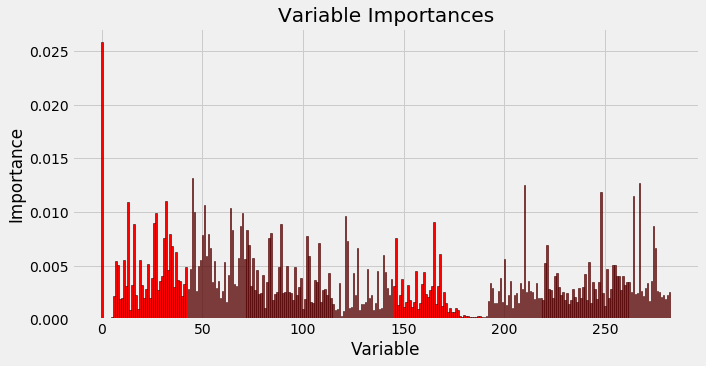

In [105]:

# Reset style 
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10,5)
# list of x locations for plotting
x_values = [x for x in range(len(importances))]

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 0.5)

# Tick labels for x axis
#plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');


Clearly, there are some features with higher importance and some with almost negligible. We will remove these from our dataset as they are damaging.

In [18]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)


# Find number of features for cumulative importance of 85%
# Add 1 because Python is zero-indexed
print('Number of features for 85% importance:', np.where(cumulative_importances > 0.85)[0][0] + 1)

Number of features for 85% importance: 173


In [42]:
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:160]]
# Find the columns of the most important features
important_indices = [feature_list.index(feature) for feature in important_feature_names]

# Create training and testing sets with only the important features
X_train_selected = X_train.iloc[:,important_indices]
#X_test_selected = X_test.iloc[:,important_indices]

# Sanity check on operations
print('Important train features shape:', X_train_selected.shape)

Important train features shape: (6385, 160)


Run the model again and check:

In [62]:
scores = cross_val_score(clf, X_train_selected, y_train, cv=custom_cv)
print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.8149 (+/- 0.28)


Accuracy increased by 1.5% by reducing more than 120 features as input.

## Doing Grid Search for tuning hyperparameters:

## Grid Search 1: [number of decision trees]

In [55]:
gs = GridSearchCV(RandomForestClassifier(random_state=4,n_jobs=-1), {
    'n_estimators':[100,200,500,1000]
    }, cv = custom_cv, verbose = 2, n_jobs=-1)

In [56]:
gs.fit(X_train_selected, y_train)

Fitting 15 folds for each of 4 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.9min finished


GridSearchCV(cv=[(array([ 440,  441,  442, ..., 6382, 6383, 6384]),
                  array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  9...
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
         

In [93]:
gs_results = pd.DataFrame(gs.cv_results_)
gs_results.iloc[:,[5,21,22,23]]

,params,mean_test_score,std_test_score,rank_test_score
0,{'n_estimators': 100},0.814882,0.140142,4
1,{'n_estimators': 200},0.817794,0.140692,3
2,{'n_estimators': 500},0.821728,0.148326,2
3,{'n_estimators': 1000},0.826628,0.150083,1


In [58]:
gs.best_params_

{'n_estimators': 1000}

In [59]:
gs.best_score_

0.8266279323294504

1000 trees gives the best result!

## Grid Search 2: [max depth]

In [63]:
gs1 = GridSearchCV(RandomForestClassifier(n_estimators = 1000, random_state=4,n_jobs=-1), {
    'max_depth':[10, 20, 40, 100, None]
    }, cv = custom_cv, verbose = 2, n_jobs=-1)

In [64]:
gs1.fit(X_train_selected, y_train)

Fitting 15 folds for each of 5 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 13.7min finished


GridSearchCV(cv=[(array([ 440,  441,  442, ..., 6382, 6383, 6384]),
                  array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  9...
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
         

In [95]:
gs1_results = pd.DataFrame(gs1.cv_results_)
gs1_results.iloc[:,[5,21,22,23]]

,params,mean_test_score,std_test_score,rank_test_score
0,{'max_depth': 10},0.813316,0.147946,5
1,{'max_depth': 20},0.825703,0.148177,4
2,{'max_depth': 40},0.826628,0.150083,1
3,{'max_depth': 100},0.826628,0.150083,1
4,{'max_depth': None},0.826628,0.150083,1


Keep 160 selected features in test input df

In [66]:
X_test_selected = X_test.iloc[:,important_indices]
X_test_selected.shape

(1738, 160)

# Final Result on test data

In [91]:
#Checking final result(using test data)
model = rf_cls(X_train_selected, y_train, X_test_selected, y_test)

OOB Score =  0.9880971025841817
Test Accuracy =  0.9275028768699655
f1 score =  0.9265796145148634


## Printing Confusion Matrix:

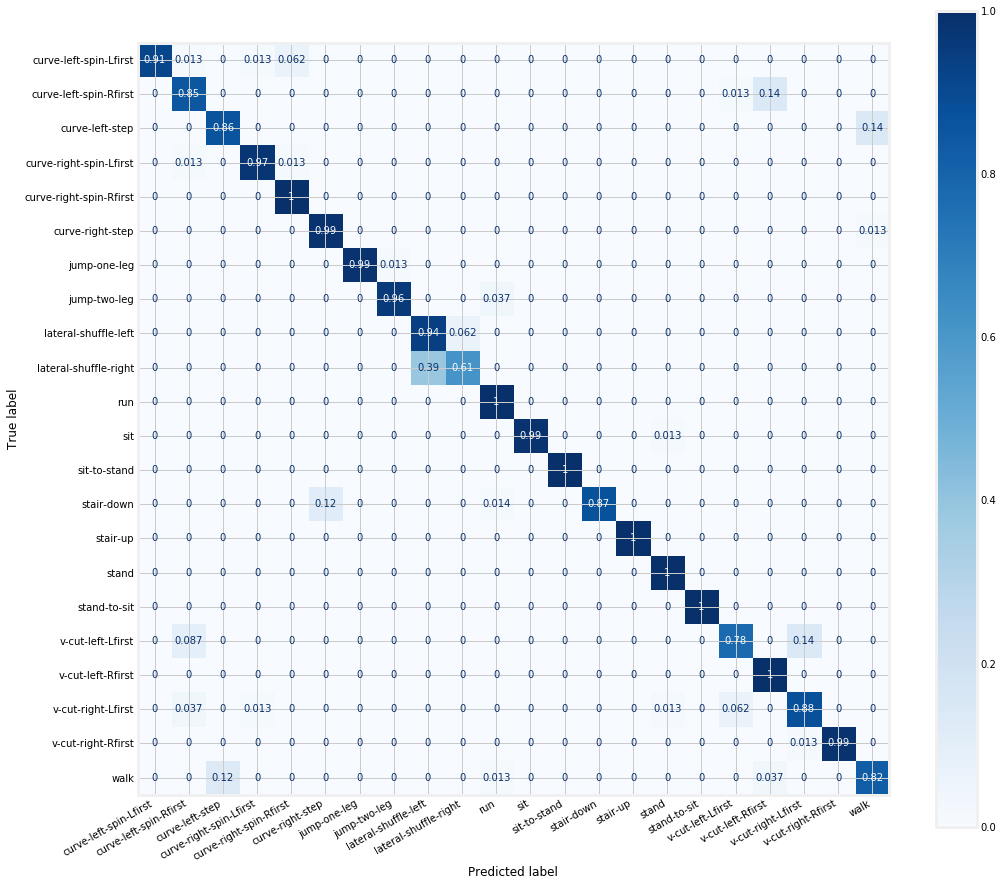

In [89]:
descriptive_labels = ['curve-left-spin-Lfirst', 'curve-left-spin-Rfirst', 'curve-left-step', 'curve-right-spin-Lfirst',
       'curve-right-spin-Rfirst', 'curve-right-step', 'jump-one-leg', 'jump-two-leg', 'lateral-shuffle-left', 'lateral-shuffle-right',
       'run', 'sit', 'sit-to-stand', 'stair-down', 'stair-up', 'stand','stand-to-sit', 'v-cut-left-Lfirst', 'v-cut-left-Rfirst',
       'v-cut-right-Lfirst', 'v-cut-right-Rfirst', 'walk']

plt.rcParams['figure.figsize'] = (15,15)

plot_confusion_matrix(model, X_test_selected, y_test,
                                 display_labels=descriptive_labels,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.xticks(rotation=30, ha='right')
plt.show()

# Checking other models

## SVC

In [99]:
from sklearn.svm import SVC

svc = SVC()
svc_scores = cross_val_score(svc, X_train.drop(['Subject'], axis=1), y_train, cv=custom_cv)

print("Accuracy: %0.2f (+/- %0.2f)" % (svc_scores.mean(), svc_scores.std() * 2))

Accuracy: 0.50 (+/- 0.28)


## KNN with feature selection

In [102]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.neighbors import KNeighborsClassifier

X_knn = SelectKBest(f_classif, k=16).fit_trakmnsform(X_train.drop(['Subject'],axis=1), y_train)
X_knn.shape

(6130, 16)

In [106]:
neigh = KNeighborsClassifier(n_neighbors=10)
knn_scores = cross_val_score(neigh, X_knn, y_train, cv=custom_cv)

print("Accuracy: %0.2f (+/- %0.2f)" % (knn_scores.mean(), knn_scores.std() * 2))

Accuracy: 0.47 (+/- 0.11)
